In [1]:
import pandas as pd

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.utils import plot_model

import keras

import optuna

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import (
    accuracy_score,
    f1_score
)

from imblearn.over_sampling import SMOTE

c:\Users\micha\anaconda3\envs\msds-data-science-project\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# 1. Load the dataset
df = pd.read_csv("datasets/3. online_shoppers_intention_clean.csv")

# 2. Select relevant columns
df = df[[
    "Administrative", "Informational", "ProductRelated",
    "BounceRates", "ExitRates", "PageValues", "Month",
    "TrafficType", "VisitorType", "Revenue"
]]

# 3. Separate input features and target
X = df.drop(columns=["Revenue"])
y = df["Revenue"]

# 4. Split the data into train_val and test sets (80% train_val, 20% test)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 5. Split the train_val into training and validation sets (75% train, 25% val)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val
)  # 0.25 x 0.8 = 0.2

# 6. Define numerical and categorical columns
numerical_features = [
    "Administrative", "Informational", "ProductRelated",
    "BounceRates", "ExitRates", "PageValues"
]
categorical_features = ["Month", "TrafficType", "VisitorType"]

# 7. Preprocess numerical features
min_max_scaler = MinMaxScaler()
min_max_scaler.fit(X_train[numerical_features])

# Transform the numerical features
X_train_scaled = min_max_scaler.transform(X_train[numerical_features])
X_val_scaled = min_max_scaler.transform(X_val[numerical_features])
X_test_scaled = min_max_scaler.transform(X_test[numerical_features])

# Convert scaled arrays back to dataframes for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=numerical_features, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=numerical_features, index=X_val.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=numerical_features, index=X_test.index)

# 8. Preprocess categorical features
# Initialise the OneHotEncoder
one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False) # sparse_output=False turns the data into NumPy array

# Fit the encoder on the training data
one_hot_encoder.fit(X_train[categorical_features])

# Transform the categorical features
X_train_encoded = one_hot_encoder.transform(X_train[categorical_features])
X_val_encoded = one_hot_encoder.transform(X_val[categorical_features])
X_test_encoded = one_hot_encoder.transform(X_test[categorical_features])

# Get the new feature names after one-hot encoding
encoded_feature_names = one_hot_encoder.get_feature_names_out(categorical_features)

# Convert encoded arrays back to dataframes
X_train_encoded = pd.DataFrame(X_train_encoded, columns=encoded_feature_names, index=X_train.index)
X_val_encoded = pd.DataFrame(X_val_encoded, columns=encoded_feature_names, index=X_val.index)
X_test_encoded = pd.DataFrame(X_test_encoded, columns=encoded_feature_names, index=X_test.index)

# 9. Combine processed features
X_train_processed = pd.concat([X_train_scaled, X_train_encoded], axis=1)
X_val_processed = pd.concat([X_val_scaled, X_val_encoded], axis=1)
X_test_processed = pd.concat([X_test_scaled, X_test_encoded], axis=1)

# Verify the shapes
print("Processed Training Data Shape:", X_train_processed.shape)
print("Processed Validation Data Shape:", X_val_processed.shape)
print("Processed Test Data Shape:", X_test_processed.shape)

# 10. Apply SMOTE to the training data
# smote = SMOTE(random_state=42)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)

# Verify the resampled data
# print("Resampled Training Data Shape:", X_train_resampled.shape)
# print("Resampled Training Target Distribution:\n", y_train_resampled.value_counts())

# 11. Reset indices
X_train_processed.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

X_val_processed.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)

X_test_processed.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

# 12. Final verification
print("Final Training Data Shape:", X_train_processed.shape)
print("Final Validation Data Shape:", X_val_processed.shape)
print("Final Test Data Shape:", X_test_processed.shape)

Processed Training Data Shape: (7334, 38)
Processed Validation Data Shape: (2445, 38)
Processed Test Data Shape: (2445, 38)
Final Training Data Shape: (7334, 38)
Final Validation Data Shape: (2445, 38)
Final Test Data Shape: (2445, 38)


# WARNING: DO NOT RUN THE CELL BELOW IF YOU DO NOT WANT TO RUN OPTIMISATION, AS IT MAY TAKE HOURS TO DAYS TO COMPLETE

In [ ]:
# 13. Set seed for reproducability
keras.utils.set_random_seed(42)

# 14. Define the function to create NN model
def create_model(trial):
    # Hyperparameters to tune
    n_hidden_layers = trial.suggest_int('n_hidden_layers', 1, 3)
    activation = trial.suggest_categorical('activation', ['relu', 'tanh', 'elu'])
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'rmsprop', 'sgd'])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    n_neurons = trial.suggest_int('n_neurons', 16, 128) 
    
    # Choose the optimizer
    optimizer = {
        'adam': Adam(learning_rate=learning_rate),
        'rmsprop': RMSprop(learning_rate=learning_rate),
        'sgd': SGD(learning_rate=learning_rate)
    }[optimizer_name]
    
    # Build the model
    model = Sequential()
    
    # Add Input layer
    model.add(Input(shape=(X_train_processed.shape[1],))) # Dynamically adjusts based on the number of columns of the dataset
    
    # First hidden layer
    model.add(Dense(n_neurons, activation=activation))
    
    # Additional hidden layers
    for i in range(n_hidden_layers - 1): # -1 as already added the first layer
        model.add(Dense(n_neurons, activation=activation))
        model.add(Dropout(dropout_rate)) # Add dropout layer to minimise overfitting
    
    # Output layer for binary classification
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# 15. Define the objective function for Optuna
def objective(trial):
    try:
        # Create the model
        model = create_model(trial)
        
        # Suggest batch size
        batch_size = trial.suggest_categorical('batch_size', [1, 2, 4, 8, 16, 32, 64, 128])
        
        # Define early stopping
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=20
        )
        
        # Train the model
        history = model.fit(
            X_train_processed, y_train,
            validation_data=(X_val_processed, y_val),
            epochs=100,
            batch_size=batch_size,
            callbacks=[early_stopping],
            verbose=0
        )
        
        # Evaluate the model on validation data
        score = model.evaluate(X_val_processed, y_val, verbose=0)
        return score[1]  # Return validation accuracy

    finally:
        # Clear keras session to free memory
        K.clear_session()

# 16. Create the study
study_name = "neural_network_optimisation_2"
storage_name = "sqlite:///optuna_study_neural_network_2.db" # Use .db so that a record store of all trials will be saved

study = optuna.create_study(
    study_name=study_name,
    storage=storage_name,
    load_if_exists=True,
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=42))  

# 17. Optimise the objective function with 1000 trials
study.optimize(objective, n_trials=1000, timeout=None, show_progress_bar=True)

# 18. Retrieve and display the best trial
print("\nBest trial:")
trial = study.best_trial
print(f"  Validation Accuracy: {trial.value:.4f}")
print("  Hyperparameters: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2024-10-20 14:41:05,354] Using an existing study with name 'neural_network_optimisation_2' instead of creating a new one.
Best trial: 368. Best value: 0.898569:  17%|█▋        | 1/6 [02:35<12:55, 155.13s/it]

[I 2024-10-20 14:43:40,480] Trial 996 finished with value: 0.8912065625190735 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.00039202620137183627, 'optimizer': 'adam', 'dropout_rate': 0.238022768039796, 'n_neurons': 126, 'batch_size': 2}. Best is trial 368 with value: 0.8985685110092163.


Best trial: 368. Best value: 0.898569:  33%|███▎      | 2/6 [04:58<09:53, 148.29s/it]

[I 2024-10-20 14:46:03,978] Trial 997 finished with value: 0.8932515382766724 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.0004547302619182996, 'optimizer': 'adam', 'dropout_rate': 0.22261155389429862, 'n_neurons': 52, 'batch_size': 2}. Best is trial 368 with value: 0.8985685110092163.


Best trial: 368. Best value: 0.898569:  50%|█████     | 3/6 [06:29<06:05, 121.91s/it]

[I 2024-10-20 14:47:34,510] Trial 998 finished with value: 0.8924335241317749 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.0005579779492671229, 'optimizer': 'adam', 'dropout_rate': 0.21410442720727474, 'n_neurons': 124, 'batch_size': 2}. Best is trial 368 with value: 0.8985685110092163.


Best trial: 368. Best value: 0.898569:  67%|██████▋   | 4/6 [08:38<04:09, 124.79s/it]

[I 2024-10-20 14:49:43,704] Trial 999 finished with value: 0.89570552110672 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.0005169174417585566, 'optimizer': 'adam', 'dropout_rate': 0.23302226089611605, 'n_neurons': 121, 'batch_size': 2}. Best is trial 368 with value: 0.8985685110092163.


Best trial: 368. Best value: 0.898569:  83%|████████▎ | 5/6 [10:49<02:06, 126.93s/it]

[I 2024-10-20 14:51:54,430] Trial 1000 finished with value: 0.8952965140342712 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.0003824874289323037, 'optimizer': 'adam', 'dropout_rate': 0.2074370248744262, 'n_neurons': 128, 'batch_size': 2}. Best is trial 368 with value: 0.8985685110092163.


Best trial: 368. Best value: 0.898569: 100%|██████████| 6/6 [13:33<00:00, 135.53s/it]

[I 2024-10-20 14:54:38,515] Trial 1001 finished with value: 0.8928425312042236 and parameters: {'n_hidden_layers': 3, 'activation': 'elu', 'learning_rate': 0.0002822702178470445, 'optimizer': 'adam', 'dropout_rate': 0.2268615749371727, 'n_neurons': 123, 'batch_size': 2}. Best is trial 368 with value: 0.8985685110092163.

Best trial:
  Validation Accuracy: 0.8986
  Hyperparameters: 
    n_hidden_layers: 3
    activation: elu
    learning_rate: 0.0007226368047121741
    optimizer: adam
    dropout_rate: 0.22850243174773258
    n_neurons: 121
    batch_size: 4


# Please continue running the cells from here on to skip optimisation and train with the best found hyperparameters

In [4]:
# 19. Train the final model on combined training and validation data with best hyperparameters

# Load the Optuna study to retrieve the best trial
study_name = "neural_network_optimisation_2"
storage_name = "sqlite:///optuna_study_neural_network_2.db"

# Load the existing study
study = optuna.load_study(
    study_name=study_name,
    storage=storage_name
)

# Retrieve the best trial
best_trial = study.best_trial

# Extract the best hyperparameters
best_params = best_trial.params

print("\nBest Hyperparameters from Optuna Study:")
for key, value in best_params.items():
    print(f"  {key}: {value}")


Best Hyperparameters from Optuna Study:
  n_hidden_layers: 3
  activation: elu
  learning_rate: 0.0007226368047121741
  optimizer: adam
  dropout_rate: 0.22850243174773258
  n_neurons: 121
  batch_size: 4


In [5]:
# Set seed
keras.utils.set_random_seed(42)

# Combine training and validation data
X_combined = pd.concat([X_train_processed, X_val_processed], axis=0)
y_combined = pd.concat([y_train, y_val], axis=0) 

# Apply SMOTE to the combined data
# smote = SMOTE(random_state=42)
# X_combined_resampled, y_combined_resampled = smote.fit_resample(X_combined, y_combined)

print("\nCombined Resampled Data Shape:", X_combined.shape)
print("Combined Resampled Target Distribution:\n", y_combined.value_counts())

# Define a function to create the keras model with best hyperparameters
def build_best_model(params):
    # Extract hyperparameters
    n_hidden_layers = params['n_hidden_layers']
    activation = params['activation']
    learning_rate = params['learning_rate']
    optimizer_name = params['optimizer']
    dropout_rate = params['dropout_rate']
    n_neurons = params['n_neurons']
    
    # Choose the optimiser
    optimizer = {
        'adam': Adam(learning_rate=learning_rate),
        'rmsprop': RMSprop(learning_rate=learning_rate),
        'sgd': SGD(learning_rate=learning_rate)
    }[optimizer_name]
    
    # Build the model
    model = Sequential()
    
    # Input layer
    model.add(Input(shape=(X_combined.shape[1],)))
    
    # First hidden layer
    model.add(Dense(n_neurons, activation=activation))
    
    # Additional hidden layers
    for _ in range(n_hidden_layers - 1):
        model.add(Dense(n_neurons, activation=activation))
        model.add(Dropout(dropout_rate))
    
    # Output layer
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Build the best model
final_model = build_best_model(best_params)

# Define early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

# Train the final model
history = final_model.fit(
    X_combined, y_combined,
    validation_data=(X_test_processed, y_test),
    epochs=100,
    batch_size=best_params['batch_size'],
    callbacks=[early_stopping],
    verbose=1
)

# Make predictions on the combined training data
y_train_pred_prob = final_model.predict(X_combined)
y_train_pred = (y_train_pred_prob > 0.5).astype(int).reshape(-1)

# Calculate training accuracy & F1 score
training_accuracy = accuracy_score(y_combined, y_train_pred)
print(f"Training Accuracy: {training_accuracy:.2f}")
training_f1 = f1_score(y_combined, y_train_pred)
print(f"Training F1 Score: {training_f1:.2f}")

# Make predictions on the test data
y_test_pred_prob = final_model.predict(X_test_processed)
y_test_pred = (y_test_pred_prob > 0.5).astype(int).reshape(-1)

# Calculate test accuracy & F1 score
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.2f}")
test_f1 = f1_score(y_test, y_test_pred)
print(f"Test F1 Score: {test_f1:.2f}")


Combined Resampled Data Shape: (9779, 38)
Combined Resampled Target Distribution:
 Revenue
False    8252
True     1527
Name: count, dtype: int64
Epoch 1/100
2445/2445 ━━━━━━━━━━━━━━━━━━━━ 2s 707us/step - accuracy: 0.8484 - loss: 0.3906 - val_accuracy: 0.8736 - val_loss: 0.3277
Epoch 2/100
2445/2445 ━━━━━━━━━━━━━━━━━━━━ 2s 666us/step - accuracy: 0.8730 - loss: 0.3239 - val_accuracy: 0.8822 - val_loss: 0.3131
Epoch 3/100
2445/2445 ━━━━━━━━━━━━━━━━━━━━ 2s 696us/step - accuracy: 0.8765 - loss: 0.3071 - val_accuracy: 0.8892 - val_loss: 0.2994
Epoch 4/100
2445/2445 ━━━━━━━━━━━━━━━━━━━━ 2s 674us/step - accuracy: 0.8790 - loss: 0.2990 - val_accuracy: 0.8937 - val_loss: 0.2863
Epoch 5/100
2445/2445 ━━━━━━━━━━━━━━━━━━━━ 2s 667us/step - accuracy: 0.8833 - loss: 0.2925 - val_accuracy: 0.8928 - val_loss: 0.2793
Epoch 6/100
2445/2445 ━━━━━━━━━━━━━━━━━━━━ 2s 664us/step - accuracy: 0.8852 - loss: 0.2877 - val_accuracy: 0.8957 - val_loss: 0.2720
Epoch 7/100
2445/2445 ━━━━━━━━━━━━━━━━━━━━ 2s 688us/step

In [5]:
# 20. Print model summary
final_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 121)            │         4,719 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 121)            │        14,762 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 121)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 121)            │        14,762 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 121)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           122 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,097 (402.73 KB)

 Trainable params: 34,365 (134.24 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 68,732 (268.49 KB)

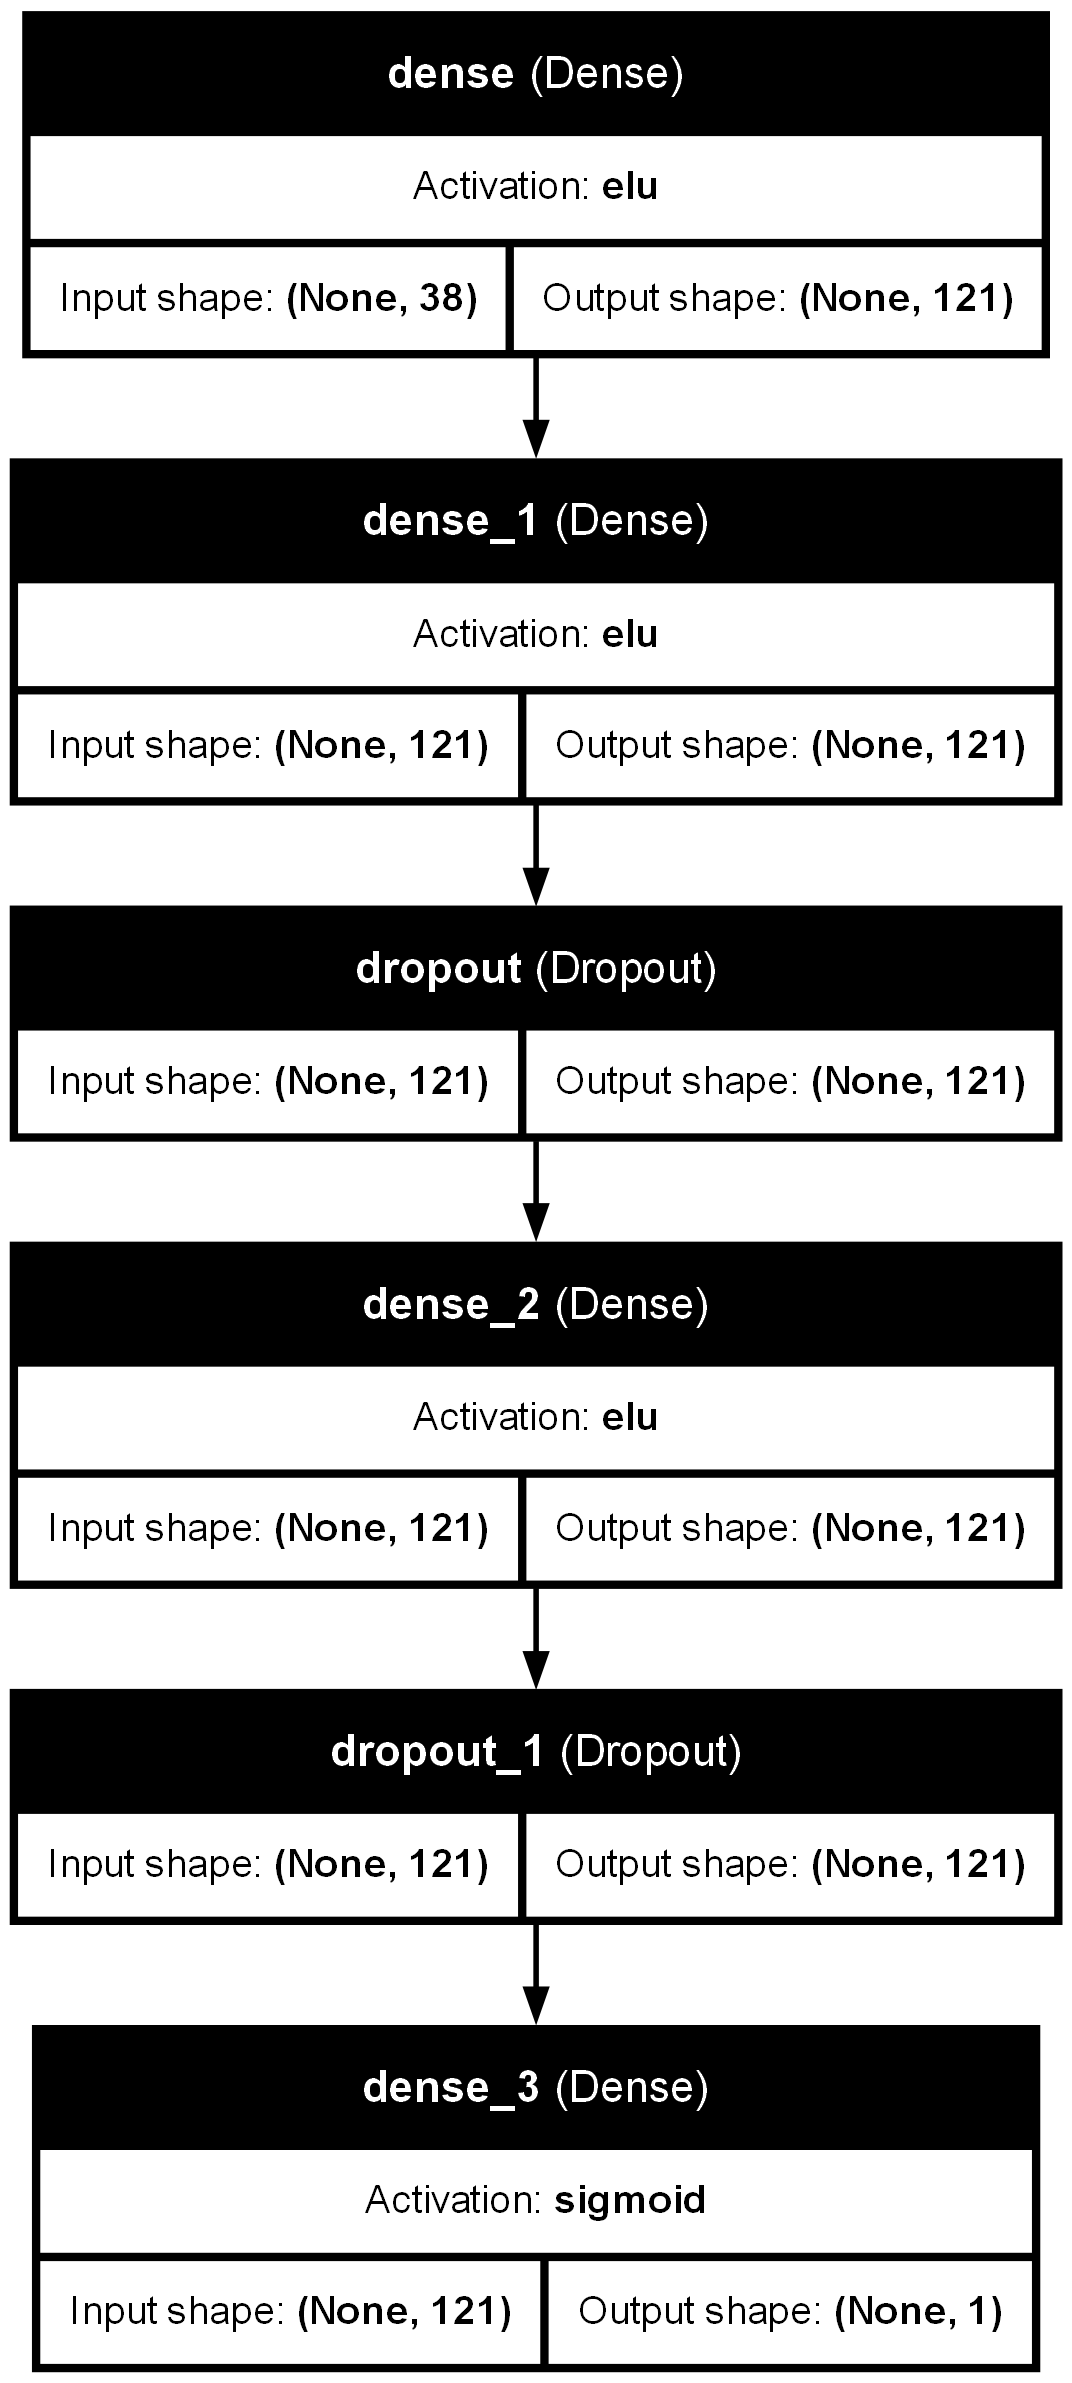

In [6]:
# 21. Plot model diagram
plot_model(final_model, to_file='NN2.png', show_shapes=True, show_layer_names=True, show_layer_activations=True)

In [4]:
# 22. Check inference speed on test set
%timeit -r 10 -n 100 y_test_pred_prob = final_model.predict(X_test_processed)

 1/77 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step
77/77 ━━━━━━━━━━